## 1. Import Libraries

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
import missingno

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('wordnet')
# all text data, convert numbers to words, only letter, lower case
from num2words import num2words
from ftfy import fix_text
import re


import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from wordcloud import WordCloud

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
# Load the data and check the first few lines
dataset_path = "fake_job_postings.csv"
dataset = pd.read_csv(dataset_path)
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


### Basic Understanding of the Data

In [11]:
print(dataset.shape)
dataset.info()

(17880, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  obje

In [12]:
dataset.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

<Axes: >

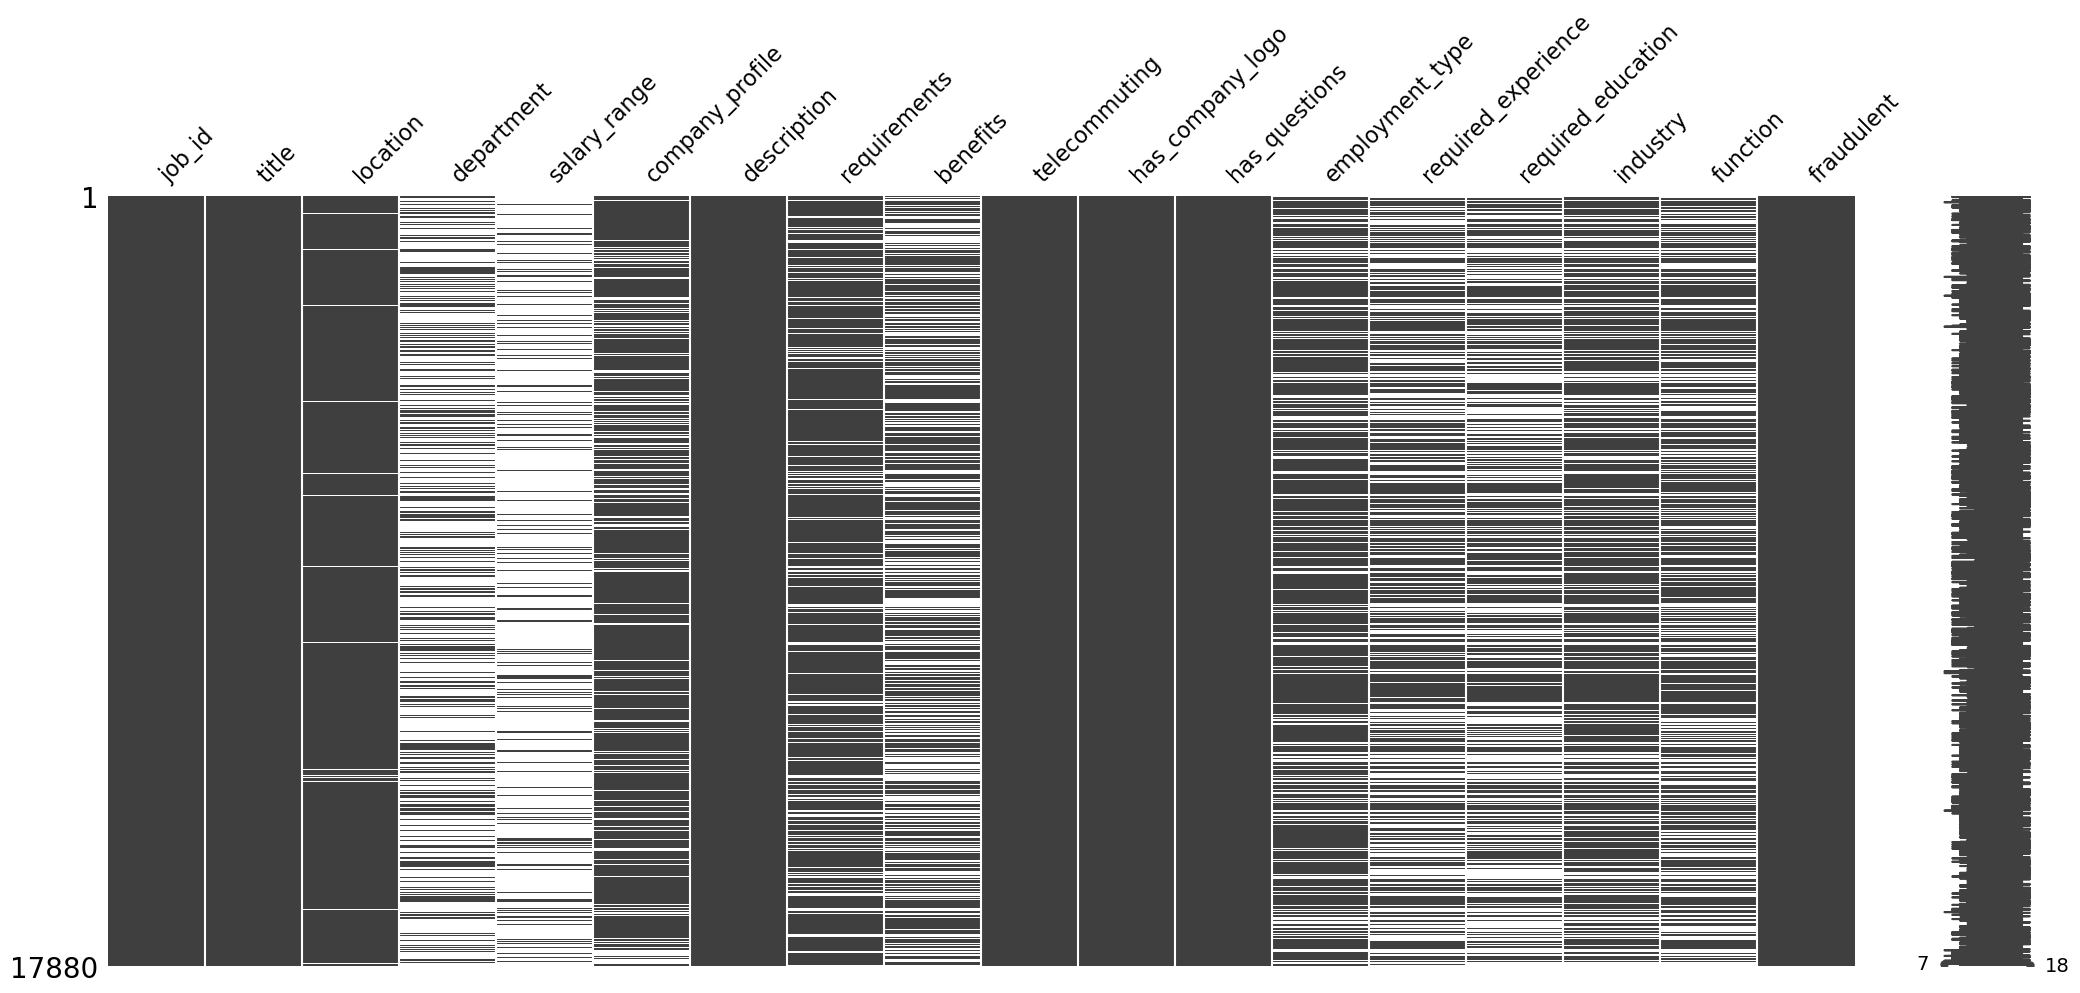

In [13]:
#Alternative way to have a quick glance to check missing values
missingno.matrix(dataset)

In [14]:
dataset.duplicated().sum()

0

From the data, we understand that there are 0 duplicated rows and there are a lot of data columns that has a lot of NA values especially department and salary range. This folows up required_education, benefits and required_experience. We will dive deep to understand each data columns better to make a decision if we want to drop the column or not. 

## 2. Data Cleaning

Columns with missing value: 

location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455

In [15]:
dataset['have_company_profile'] = np.where(dataset['company_profile'].notnull(), 1, 0)
dataset['have_description'] = np.where(dataset['description'].notnull(), 1, 0)
dataset['have_requirements'] = np.where(dataset['requirements'].notnull(), 1, 0)
dataset['have_benefits'] = np.where(dataset['benefits'].notnull(), 1, 0)
dataset['have_department'] = np.where(dataset['department'].notnull(), 1, 0)

In [16]:
# combine texts
dataset[['company_profile']] = dataset[['company_profile']].fillna('')
dataset[['description']] = dataset[['description']].fillna('')
dataset[['requirements']] = dataset[['requirements']].fillna('')
dataset[['benefits']] = dataset[['benefits']].fillna('')
dataset[['department']] = dataset[['department']].fillna('')
dataset['full_text'] = dataset['company_profile'] + ' ' + dataset['description'] + ' ' + dataset['requirements'] + ' ' + dataset['benefits']+ ' ' + dataset['department']

del dataset['company_profile']
del dataset['description']
del dataset['requirements']
del dataset['benefits']
del dataset['department']
dataset.head()

,job_id,title,location,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,have_company_profile,have_description,have_requirements,have_benefits,have_department,full_text
0,1,Marketing Intern,"US, NY, New York",NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,1,1,1,0,1,"We're Food52, and we've created a groundbreaki..."
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",NaN,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,1,1,1,1,1,"90 Seconds, the worlds Cloud Video Production ..."
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,1,1,1,0,0,Valor Services provides Workforce Solutions th...
3,4,Account Executive - Washington DC,"US, DC, Washington",NaN,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,1,1,1,1,1,Our passion for improving quality of life thro...
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,1,1,1,1,0,SpotSource Solutions LLC is a Global Human Cap...


In [17]:
#split location
dataset['location_country'] = dataset['location'].str.split(',').str[0]
dataset['location_county'] = dataset['location'].str.split(',').str[1]
dataset['location_city'] = dataset['location'].str.split(',').str[2]
del dataset['location']

In [19]:
# fill in with 'unknown': location_country,county,city,employment_type,required_experience,required_education,industry,function
dataset[['employment_type','required_experience','required_education','industry','function','location_country','location_county','location_city']] \
= dataset[['employment_type','required_experience','required_education','industry','function','location_country','location_county','location_city']].fillna('unavailable')

In [24]:
# bin then fill in with most common: salary_group, but still keep salary_range, fill in with 'unknown' and use frequency encoding
dataset['salary_group'] = dataset['salary_range']

In [25]:
for idx in (dataset['salary_group'].dropna()).index:
    Range = dataset.at[idx , 'salary_group'].split('-')
    try :
        starts = int(Range[0])
        if len(Range)==2:
          ends = int(Range[1])
        else:
          ends = starts
        salary = (starts + ends)/2
        if salary <= 1000:
          dataset.at[idx ,'salary_group'] = 'Extremely Low'
        elif salary > 1000 and salary <= 30000:
          dataset.at[idx ,'salary_group'] = 'Low'
        elif salary > 30000 and salary <= 100000:
          dataset.at[idx ,'salary_group'] = 'Slightly Low'
        elif salary > 100000 and salary <= 500000:
          dataset.at[idx ,'salary_group'] = 'Slightly High'
        elif salary > 500000 and salary <= 1000000:
          dataset.at[idx ,'salary_group'] = 'High'
        elif salary > 1000000:
          dataset.at[idx ,'salary_group'] = 'Extremely High'

    except ValueError:
        dataset.at[idx ,'salary_group'] = 'Unavailable'

dataset['salary_group'] = dataset['salary_group'].fillna('Unavailable')
dataset['salary_range'] = dataset['salary_range'].fillna('Unavailable')

del dataset['location']

In [34]:
def remove_stop_words(doc):
  stop_words = set(nltk.corpus.stopwords.words('english'))
  docs = list(set(doc.split(' ')) - stop_words)
  return docs  # stem
def simple_stemmer(doc):
  stemmer= PorterStemmer()
  doc = ' '.join([stemmer.stem(word) for word in doc])
  return doc

# to clean data
def normalise_text(text):
    text = fix_text(text)
    text = text.lower()  # lowercase
    text = re.sub(r'\#', "", text)        # replaces hashtags
    text = re.sub(r'\xa0', ' ', text) # remove \xa0
    # remove URL addresses
    text = re.sub(r"http\S+","URL", text)
    text = re.sub(r'www\S+', '', text)
    text = re.sub(r'\d+', lambda x: num2words(x.group(), to='cardinal'), text)
    text = re.sub("[^a-zA-Z]", " ", text) # letters only
    # replace more than or equal to two white spaces into one white space.
    text = re.sub(r'\s{2,}', ' ', text)
    stop_words = set(nltk.corpus.stopwords.words('english'))
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    #stemmer= PorterStemmer()
    #text = ' '.join([stemmer.stem(word) for word in text])
    return text



In [36]:
normalise_text(dataset['full_text'].iloc[0])
dataset['full_text'] = dataset['full_text'].apply(lambda x: normalise_text(x))
dataset['text_len'] = dataset['full_text'].apply(lambda x: len(x.split(' ')))

In [37]:
dataset.head()

,job_id,title,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,have_company_profile,have_description,have_requirements,have_benefits,have_department,full_text,location_country,location_county,location_city,salary_group,text_len
0,1,Marketing Intern,0,1,0,Other,Internship,unavailable,unavailable,Marketing,0,1,1,1,0,1,foodfifty two created groundbreaking award win...,US,NY,New York,Unavailable,258
1,2,Customer Service - Cloud Video Production,0,1,0,Full-time,Not Applicable,unavailable,Marketing and Advertising,Customer Service,0,1,1,1,1,1,ninety seconds worlds cloud video production s...,NZ,,Auckland,Unavailable,590
2,3,Commissioning Machinery Assistant (CMA),0,1,0,unavailable,unavailable,unavailable,unavailable,unavailable,0,1,1,1,0,0,valor services provides workforce solutions me...,US,IA,Wever,Unavailable,232
3,4,Account Executive - Washington DC,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,1,1,1,1,1,passion improving quality life geography heart...,US,DC,Washington,Unavailable,493
4,5,Bill Review Manager,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,1,1,1,1,0,spotsource solutions llc global human capital ...,US,FL,Fort Worth,Unavailable,400


In [38]:
dataset.isna().sum()

job_id                  0
title                   0
telecommuting           0
has_company_logo        0
has_questions           0
employment_type         0
required_experience     0
required_education      0
industry                0
function                0
fraudulent              0
have_company_profile    0
have_description        0
have_requirements       0
have_benefits           0
have_department         0
full_text               0
location_country        0
location_county         0
location_city           0
salary_group            0
text_len                0
dtype: int64

## 3. Exploratory Data Analysis

- wordcut: title,department,salary_range,industry,function,company_profile,description,requirements,benefits,location

In [44]:
#drop useless column
del dataset['job_id']

In [39]:
dataset.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent,have_company_profile,have_description,have_requirements,have_benefits,have_department,text_len
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434,0.814989,0.999944,0.849217,0.596644,0.354195,272.953300
std,5161.655742,0.202631,0.403492,0.499945,0.214688,0.388317,0.007479,0.357847,0.490585,0.478282,147.869521
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,162.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,249.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,353.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1511.000000


### 3.1 Drop columns with low variance

In [43]:
# Filter numeric columns only
numeric_columns = dataset.select_dtypes(include="number")

# Calculate the variance for numeric columns
variance_info = numeric_columns.var()

# Display the variance for each numeric column
print(variance_info)


job_id                  2.664269e+07
telecommuting           4.105923e-02
has_company_logo        1.628058e-01
has_questions           2.499455e-01
fraudulent              4.609073e-02
have_company_profile    1.507905e-01
have_description        5.592841e-05
have_requirements       1.280546e-01
have_benefits           2.406733e-01
have_department         2.287536e-01
text_len                2.186540e+04
dtype: float64


In [ ]:
del dataset['have_description']

### 3.2 Understanding of variables

### 3.2 Understanding of variables

In [14]:
dataset.title.value_counts().head(5)

title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
Name: count, dtype: int64

In [15]:
dataset.title.str.strip().value_counts().head(5)

title
English Teacher Abroad                                406
Customer Service Associate                            198
Graduates: English Teacher Abroad (Conversational)    144
Customer Service Associate - Part Time                 91
Software Engineer                                      90
Name: count, dtype: int64

In [16]:
#location
dataset.location.value_counts().head(5)

location
GB, LND, London          718
US, NY, New York         658
US, CA, San Francisco    472
GR, I, Athens            464
US, ,                    339
Name: count, dtype: int64

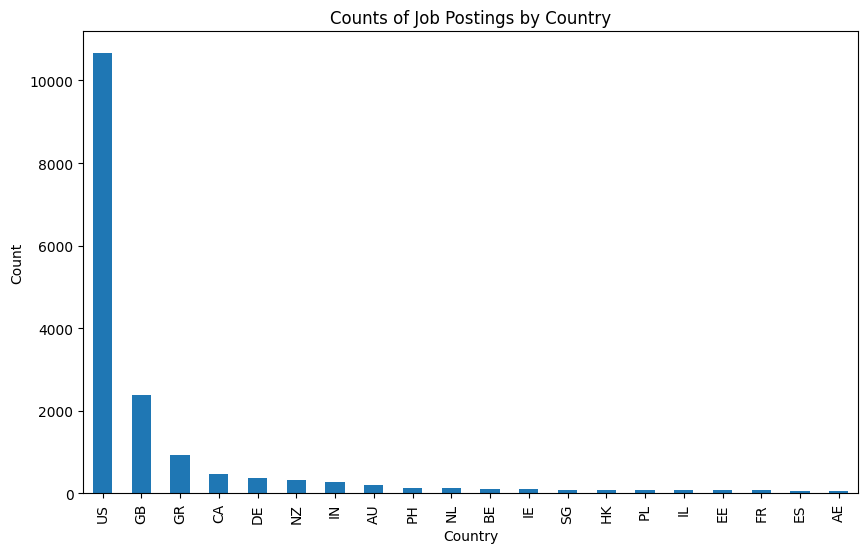

In [18]:
all_ctry = dataset['location_country'].value_counts()

top_20 = dataset['location_country'].value_counts().head(20)

plt.figure(figsize=(10, 6))
top_20.plot(kind='bar')
plt.title('Counts of Job Postings by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


In [19]:
dataset['location_county'].value_counts().head(5)

location_county
        2140
 CA     2051
 NY     1259
 LND     992
 TX      975
Name: count, dtype: int64

In [20]:
dataset['location_city'].value_counts().head(5)

location_city
                  1627
 London           1060
 New York          669
 Athens            543
 San Francisco     478
Name: count, dtype: int64

In [21]:
dataset.department.value_counts().head(5)

department
Sales          551
Engineering    487
Marketing      401
Operations     270
IT             225
Name: count, dtype: int64

In [22]:
dataset.salary_range.value_counts().head(5)

salary_range
0-0            142
40000-50000     66
30000-40000     55
25000-30000     37
45000-67000     37
Name: count, dtype: int64

In [23]:
dataset.company_profile.head(10)

0    We're Food52, and we've created a groundbreaki...
1    90 Seconds, the worlds Cloud Video Production ...
2    Valor Services provides Workforce Solutions th...
3    Our passion for improving quality of life thro...
4    SpotSource Solutions LLC is a Global Human Cap...
5                                                  NaN
6    Founded in 2009, the Fonpit AG rose with its i...
7    Airenvy’s mission is to provide lucrative yet ...
8    Solutions3 is a woman-owned small business who...
9    Novitex Enterprise Solutions, formerly Pitney ...
Name: company_profile, dtype: object

In [24]:
dataset.description.head(10)

0    Food52, a fast-growing, James Beard Award-winn...
1    Organised - Focused - Vibrant - Awesome!Do you...
2    Our client, located in Houston, is actively se...
3    THE COMPANY: ESRI – Environmental Systems Rese...
4    JOB TITLE: Itemization Review ManagerLOCATION:...
5    Job OverviewApex is an environmental consultin...
6    Your Responsibilities: Manage the English-spea...
7    Who is Airenvy?Hey there! We are seasoned entr...
8    Implementation/Configuration/Testing/Training ...
9    The Customer Service Associate will be based i...
Name: description, dtype: object

In [25]:
dataset.requirements.head(10)

0    Experience with content management systems a m...
1    What we expect from you:Your key responsibilit...
2    Implement pre-commissioning and commissioning ...
3    EDUCATION: Bachelor’s or Master’s in GIS, busi...
4    QUALIFICATIONS:RN license in the State of Texa...
5                                                  NaN
6    Your Know-How:                                ...
7    Experience with CRM software, live chat, and p...
8    MUST BE A US CITIZEN.An active TS/SCI clearanc...
9    Minimum Requirements:Minimum of 6 months custo...
Name: requirements, dtype: object

In [26]:
dataset.benefits.head(10)

0                                                  NaN
1    What you will get from usThrough being part of...
2                                                  NaN
3    Our culture is anything but corporate—we have ...
4                                Full Benefits Offered
5                                                  NaN
6    Your Benefits: Being part of a fast-growing co...
7    Competitive Pay. You'll be able to eat steak e...
8                                                  NaN
9                                                  NaN
Name: benefits, dtype: object

In [27]:
dataset.telecommuting.value_counts().head(5)

telecommuting
0    17113
1      767
Name: count, dtype: int64

In [28]:
dataset.has_company_logo.value_counts().head(5)

has_company_logo
1    14220
0     3660
Name: count, dtype: int64

In [29]:
dataset.has_questions.value_counts().head(5)

has_questions
0    9088
1    8792
Name: count, dtype: int64

In [30]:
dataset.employment_type.value_counts().head(5)

employment_type
Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: count, dtype: int64

In [31]:
dataset.required_experience.value_counts().head(5)

required_experience
Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Name: count, dtype: int64

In [32]:
dataset.required_education.value_counts().head(5)

required_education
Bachelor's Degree            5145
High School or equivalent    2080
Unspecified                  1397
Master's Degree               416
Associate Degree              274
Name: count, dtype: int64

In [33]:
dataset.industry.value_counts().head(5)

industry
Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
Name: count, dtype: int64

In [34]:
dataset.function.value_counts().head(5)

function
Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Name: count, dtype: int64

### 2.2 Relationship between features and classification target

In [35]:
dataset[dataset['fraudulent']==1]['title'].value_counts().head(5)

title
Data Entry Admin/Clerical Positions - Work From Home               21
Home Based Payroll Typist/Data Entry Clerks Positions Available    21
Cruise Staff Wanted *URGENT*                                       21
Customer Service Representative                                    17
Administrative Assistant                                           16
Name: count, dtype: int64

In [36]:
dataset[dataset['fraudulent']==0]['title'].value_counts().head(5)

title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
Name: count, dtype: int64

In [37]:
#department
dataset[dataset['fraudulent']==1]['department'].value_counts().head(5)

department
Engineering               46
Clerical                  27
Oil & Energy              24
Information Technology    15
Administrative            14
Name: count, dtype: int64

In [38]:
dataset[dataset['fraudulent']==0]['department'].value_counts().head(5)

department
Sales          539
Engineering    441
Marketing      399
Operations     270
IT             224
Name: count, dtype: int64

In [39]:
#salary_range
dataset[dataset['fraudulent']==1]['salary_range'].value_counts().head(5)


salary_range
7200-1380000     10
30000-50000       8
250000-500000     7
28000-32000       6
35000-40000       6
Name: count, dtype: int64

In [40]:
dataset[dataset['fraudulent']==0]['salary_range'].value_counts().head(5)

salary_range
0-0            138
40000-50000     65
30000-40000     51
45000-67000     37
25000-30000     32
Name: count, dtype: int64

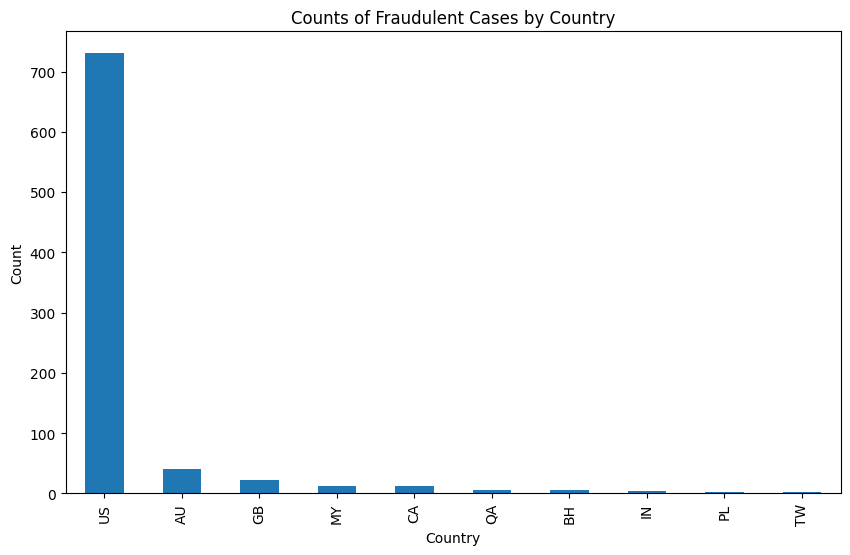

In [41]:
#location
fraudulent_ctry = dataset[dataset['fraudulent'] == 1]['location_country'].value_counts()

fraudulent_ctry_10 = fraudulent_ctry.head(10)

plt.figure(figsize=(10, 6))
fraudulent_ctry_10.plot(kind='bar')
plt.title('Counts of Fraudulent Cases by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90) 
plt.show()

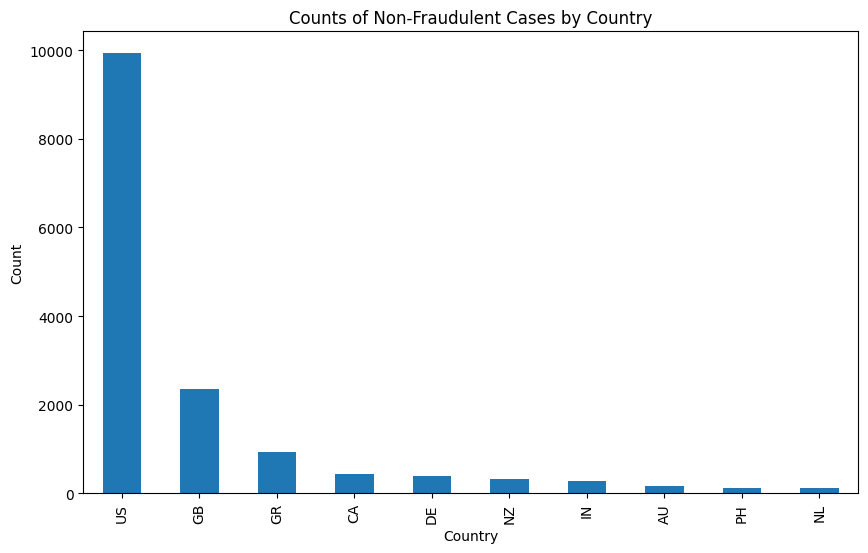

In [42]:
non_fraudulent_ctry = dataset[dataset['fraudulent'] == 0]['location_country'].value_counts()

non_fraudulent_ctry_10 = non_fraudulent_ctry.head(10)

plt.figure(figsize=(10, 6))
non_fraudulent_ctry_10.plot(kind='bar')
plt.title('Counts of Non-Fraudulent Cases by Country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=90) 
plt.show()

In [43]:
dataset[dataset['fraudulent']==1]['location_county'].value_counts().head(5)

location_county
 TX    152
 CA    143
 NY     68
        57
 MD     35
Name: count, dtype: int64

In [44]:
dataset[dataset['fraudulent']==0]['location_county'].value_counts().head(5)

location_county
        2083
 CA     1908
 NY     1191
 LND     986
 TX      823
Name: count, dtype: int64

In [45]:
dataset[dataset['fraudulent']==1]['location_city'].value_counts().head(5)

location_city
                129
 Houston         92
 Sydney          31
 Bakersfield     30
 Los Angeles     23
Name: count, dtype: int64

In [46]:
dataset[dataset['fraudulent']==0]['location_city'].value_counts().head(5)

location_city
                  1498
 London           1056
 New York          649
 Athens            543
 San Francisco     467
Name: count, dtype: int64

<Axes: xlabel='telecommuting'>

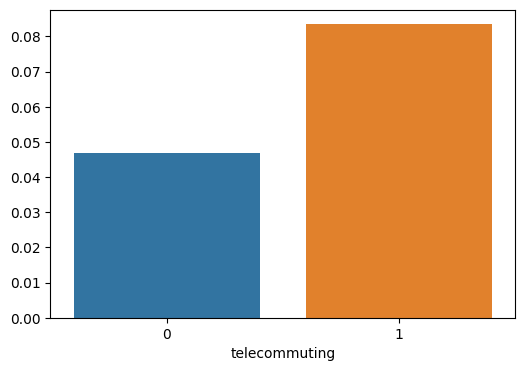

In [47]:
#telecommuting
telecommuting_fraud = dataset.groupby('telecommuting')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=telecommuting_fraud.index, y=telecommuting_fraud.values, ax=ax)

<Axes: xlabel='telecommuting', ylabel='count'>

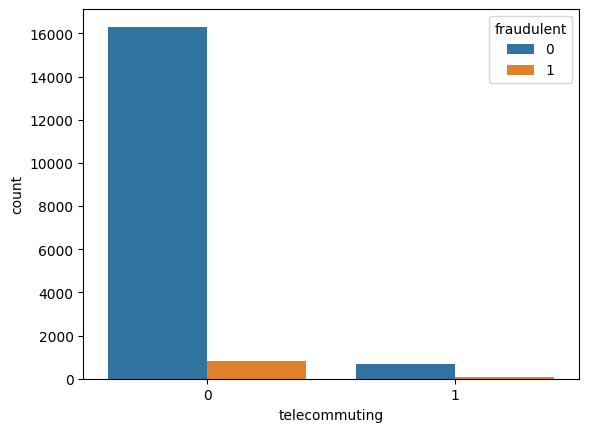

In [48]:
sns.countplot(x='telecommuting',data=dataset,hue='fraudulent')

<Axes: xlabel='has_company_logo'>

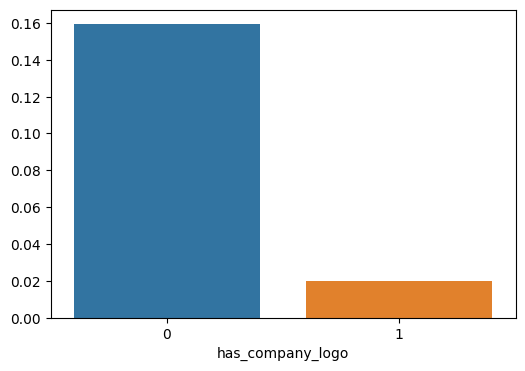

In [49]:
#has_company_logo
has_company_logo_fraud = dataset.groupby('has_company_logo')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=has_company_logo_fraud.index, y=has_company_logo_fraud.values, ax=ax)

<Axes: xlabel='has_company_logo', ylabel='count'>

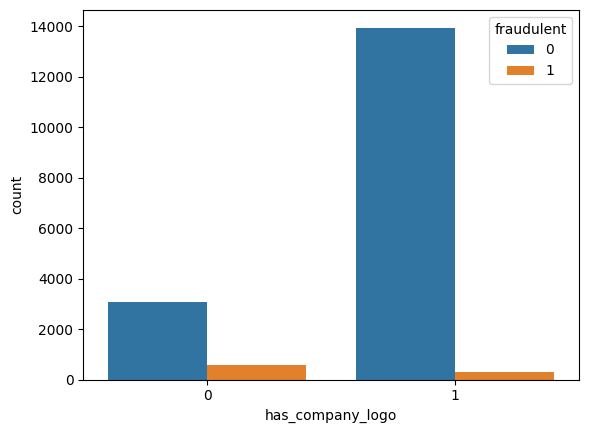

In [50]:
sns.countplot(x='has_company_logo',data=dataset,hue='fraudulent')

<Axes: xlabel='has_questions'>

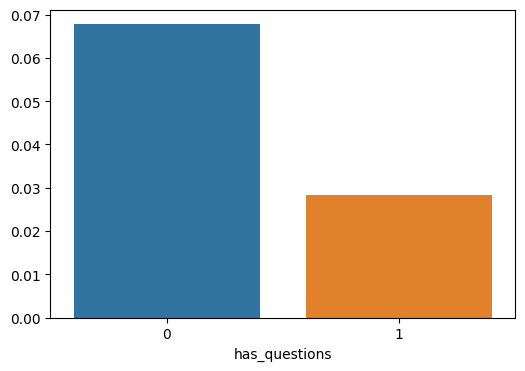

In [51]:
#has_questions
has_questions_fraud = dataset.groupby('has_questions')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.barplot(x=has_questions_fraud.index, y=has_questions_fraud.values, ax=ax)

<Axes: xlabel='has_questions', ylabel='count'>

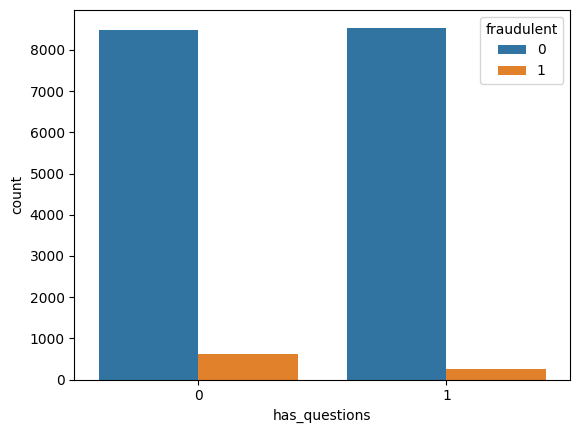

In [52]:
sns.countplot(x='has_questions',data=dataset,hue='fraudulent')

<Axes: xlabel='employment_type'>

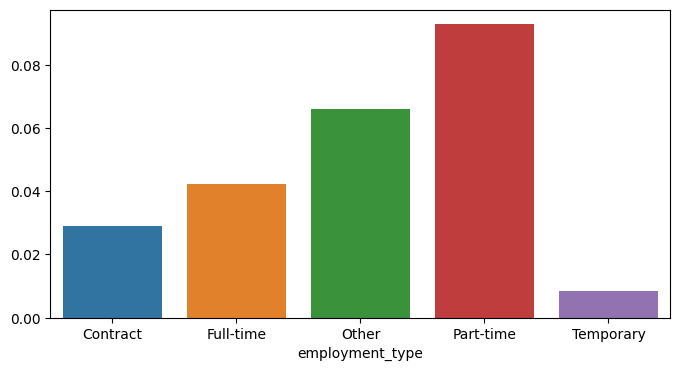

In [53]:
#employment_type
employment_type_fraud = dataset.groupby('employment_type')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.barplot(x=employment_type_fraud.index, y=employment_type_fraud.values, ax=ax)

<Axes: xlabel='employment_type', ylabel='count'>

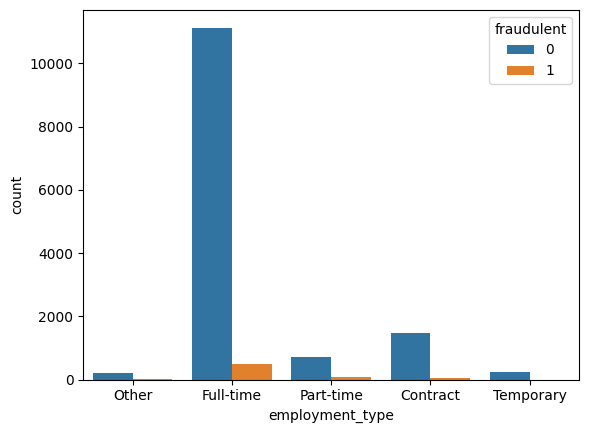

In [54]:
sns.countplot(x='employment_type',data=dataset,hue='fraudulent')

<Axes: xlabel='required_experience'>

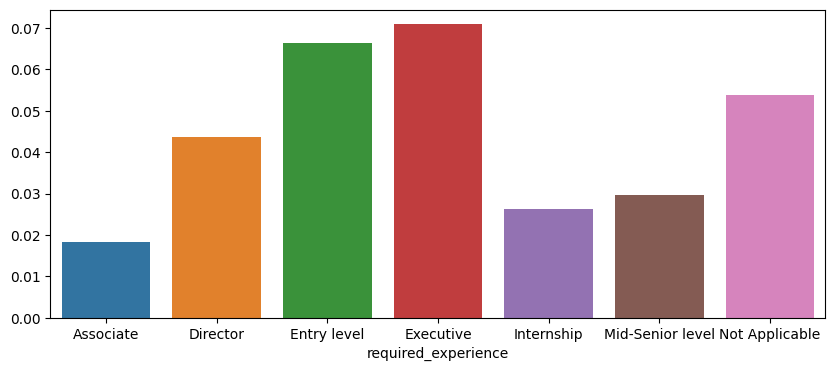

In [55]:
#required_experience
required_experience_fraud = dataset.groupby('required_experience')['fraudulent'].mean()
fig, ax = plt.subplots(1, 1, figsize=(10,4))
sns.barplot(x=required_experience_fraud.index, y=required_experience_fraud.values, ax=ax)

<Axes: xlabel='required_experience', ylabel='count'>

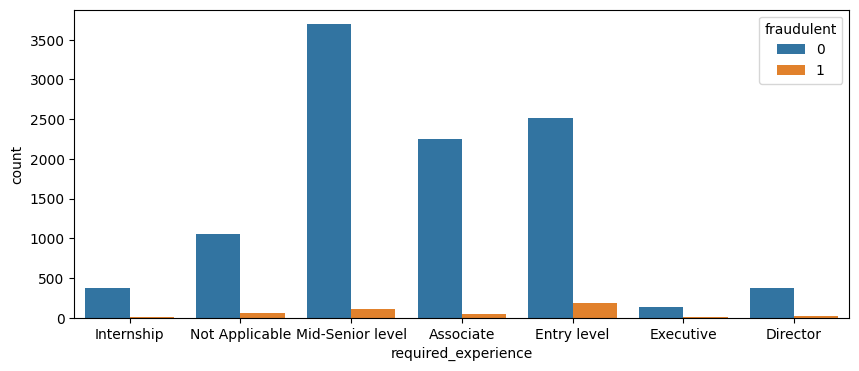

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
sns.countplot(x='required_experience',data=dataset,hue='fraudulent',ax=ax)

In [57]:
#required_education
dataset[dataset['fraudulent']==1]['required_education'].value_counts().head(5)

required_education
High School or equivalent      170
Bachelor's Degree              100
Unspecified                     61
Master's Degree                 31
Some High School Coursework     20
Name: count, dtype: int64

In [58]:
dataset[dataset['fraudulent']==0]['required_education'].value_counts().head(5)

required_education
Bachelor's Degree            5045
High School or equivalent    1910
Unspecified                  1336
Master's Degree               385
Associate Degree              268
Name: count, dtype: int64

In [59]:
#industry
dataset[dataset['fraudulent']==1]['industry'].value_counts().head(5)

industry
Oil & Energy                 109
Accounting                    57
Hospital & Health Care        51
Marketing and Advertising     45
Financial Services            35
Name: count, dtype: int64

In [60]:
dataset[dataset['fraudulent']==0]['industry'].value_counts().head(5)

industry
Information Technology and Services    1702
Computer Software                      1371
Internet                               1062
Education Management                    822
Marketing and Advertising               783
Name: count, dtype: int64

In [61]:
#function
dataset[dataset['fraudulent']==1]['function'].value_counts().head(5)

function
Administrative      119
Engineering         113
Customer Service     67
Sales                41
Other                32
Name: count, dtype: int64

In [62]:
dataset[dataset['fraudulent']==0]['function'].value_counts().head(5)

function
Information Technology    1717
Sales                     1427
Engineering               1235
Customer Service          1162
Marketing                  820
Name: count, dtype: int64

## 3. Preprocessing

- frequency encoding: title,department,salary_range,industry,function
- embeddings: company_profile,description,requirements,benefits
- one-hot encoding: others
- location: split(',') then frequency encoding

- need to strip() text
- for text dataset:  1) combine all text together and get embeddings; 2) deal with them separately and for department-like features, use frequency encoding

In [63]:
df = dataset

#df = dataset.copy()

In [64]:
# if company_profile is null, more likely to be fraudulent
dataset[dataset['company_profile'].isna()]['fraudulent'].mean()

0.17744860943168078

In [65]:
dataset[~dataset['company_profile'].isna()]['fraudulent'].mean()

0.01914630798792204

In [66]:
df['company_profile_isna'] = df['company_profile'].isna().replace({True: 1, False: 0})

### 3.1 Deal with missing values

In [68]:
# drop when description is null, only 1 record
df = df.dropna(subset=['description'])

In [69]:
# combine texts
df[['company_profile']] = df[['company_profile']].fillna('')
df[['description']] = df[['description']].fillna('')
df[['requirements']] = df[['requirements']].fillna('')
df[['benefits']] = df[['benefits']].fillna('')
df['full_text'] = df['company_profile'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['benefits']

del df['company_profile']
del df['description']
del df['requirements']
del df['benefits']

df.head()

,job_id,title,location,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,location_country,location_county,location_city,company_profile_isna,full_text
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0,US,NY,New York,0,"We're Food52, and we've created a groundbreaki..."
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,NZ,,Auckland,0,"90 Seconds, the worlds Cloud Video Production ..."
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0,US,IA,Wever,0,Valor Services provides Workforce Solutions th...
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington,0,Our passion for improving quality of life thro...
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth,0,SpotSource Solutions LLC is a Global Human Cap...


In [70]:
df[['location_country','location_county','location_city']] = df[['location_country','location_county','location_city']].replace(' ',np.NaN)

In [71]:
# fill in with 'unknown': location_country,county,city,employment_type,required_experience,required_education,industry,function
df[['employment_type','required_experience','required_education','industry','function','location_country','location_county','location_city']] \
= df[['employment_type','required_experience','required_education','industry','function','location_country','location_county','location_city']].fillna('Unknown')

In [72]:
# bin then fill in with most common: salary_group, but still keep salary_range, fill in with 'unknown' and use frequency encoding
df['salary_group'] = df['salary_range']

In [73]:
for idx in (df['salary_group'].dropna()).index:
    Range = df.at[idx , 'salary_group'].split('-')
    try :
        starts = int(Range[0])
        if len(Range)==2:
          ends = int(Range[1])
        else:
          ends = starts
        salary = (starts + ends)/2
        if salary <= 1000:
          df.at[idx ,'salary_group'] = 'Extremely Low'
        elif salary > 1000 and salary <= 30000:
          df.at[idx ,'salary_group'] = 'Low'
        elif salary > 30000 and salary <= 100000:
          df.at[idx ,'salary_group'] = 'Slightly Low'
        elif salary > 100000 and salary <= 500000:
          df.at[idx ,'salary_group'] = 'Slightly High'
        elif salary > 500000 and salary <= 1000000:
          df.at[idx ,'salary_group'] = 'High'
        elif salary > 1000000:
          df.at[idx ,'salary_group'] = 'Extremely High'

    except ValueError:
        df.at[idx ,'salary_group'] = 'Unknown'

df['salary_group'] = df['salary_group'].fillna('Unknown')
df['salary_range'] = df['salary_range'].fillna('Unknown')

In [74]:
df.groupby('salary_group')['fraudulent'].mean()

salary_group
Extremely High    0.052632
Extremely Low     0.078035
High              0.312500
Low               0.090062
Slightly High     0.053292
Slightly Low      0.073549
Unknown           0.042761
Name: fraudulent, dtype: float64

In [75]:
df[df['fraudulent']==1]['salary_group'].value_counts()

salary_group
Unknown           643
Slightly Low      109
Low                58
Extremely Low      27
Slightly High      17
High               10
Extremely High      1
Name: count, dtype: int64

In [76]:
df[df['fraudulent']==0]['salary_group'].value_counts()

salary_group
Unknown           14394
Slightly Low       1373
Low                 586
Extremely Low       319
Slightly High       302
High                 22
Extremely High       18
Name: count, dtype: int64

In [77]:
# department & location, drop
df = df.drop(['location','department'],axis=1)

In [78]:
df.isna().sum()

job_id                  0
title                   0
salary_range            0
telecommuting           0
has_company_logo        0
has_questions           0
employment_type         0
required_experience     0
required_education      0
industry                0
function                0
fraudulent              0
location_country        0
location_county         0
location_city           0
company_profile_isna    0
full_text               0
salary_group            0
dtype: int64

In [79]:
fraud_text = df[df.fraudulent == 1].full_text
nonfraud_text = df[df.fraudulent == 0].full_text


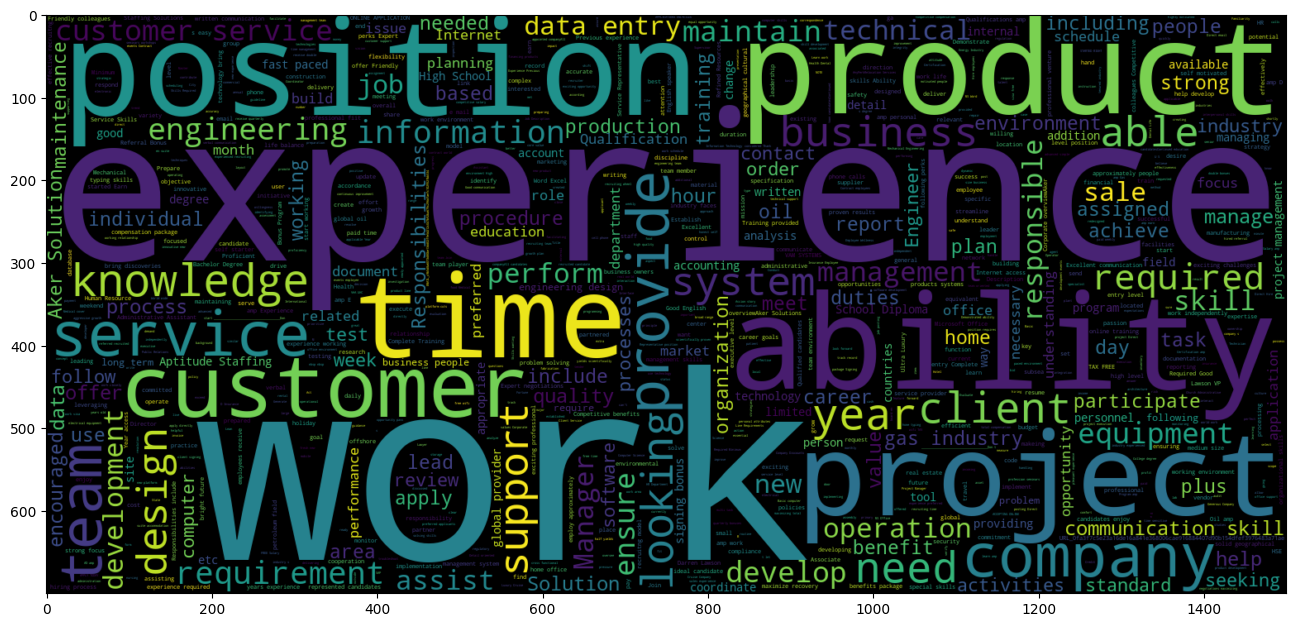

In [80]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(fraud_text)))
plt.imshow(wc,interpolation = 'bilinear')




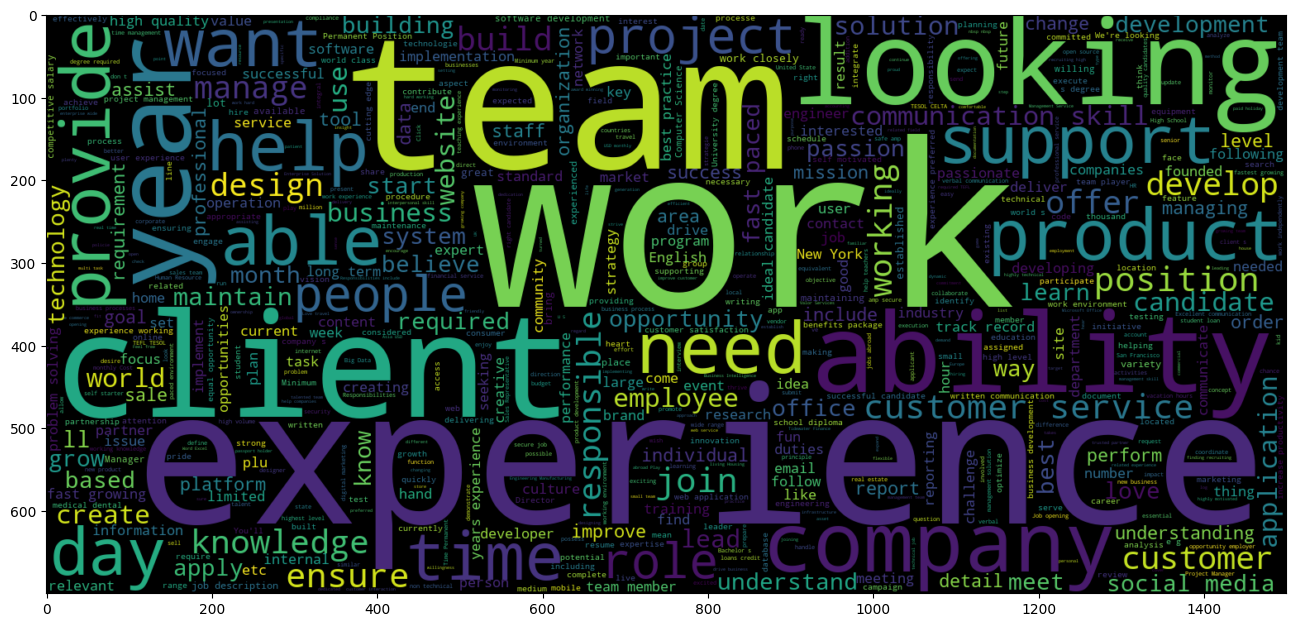

In [81]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (16,8))
wc = WordCloud(min_font_size = 3,  max_words = 2000 , width = 1500 , height = 700 , stopwords = STOPWORDS).generate(str(" ".join(nonfraud_text)))
plt.imshow(wc,interpolation = 'bilinear')


### 3.2 Clean text data

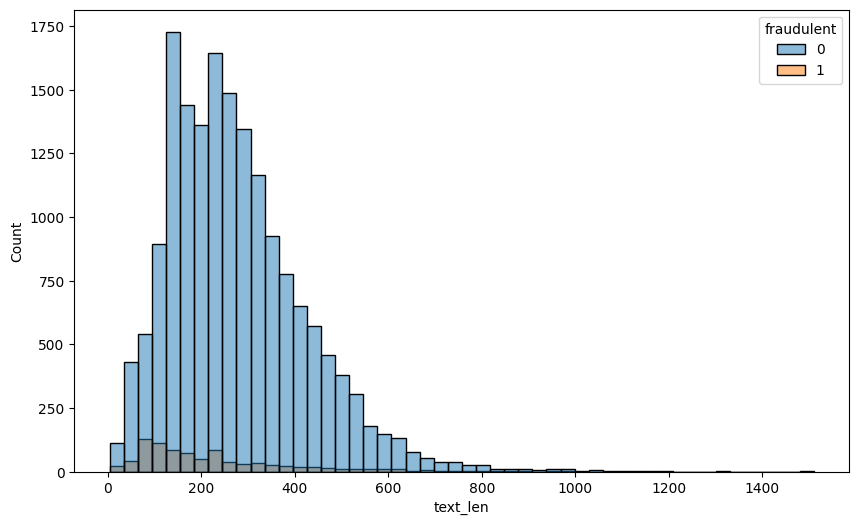

In [92]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="text_len", hue="fraudulent", kde=False, bins=50)
plt.show()

In [93]:
df['text_len'].describe()

count    17879.000000
mean       272.579003
std        147.848689
min          4.000000
25%        162.000000
50%        249.000000
75%        353.000000
max       1511.000000
Name: text_len, dtype: float64

In [94]:
df[df['fraudulent']==0]['text_len'].describe()

count    17014.000000
mean       275.143999
std        146.617035
min          7.000000
25%        164.000000
50%        252.000000
75%        355.000000
max       1511.000000
Name: text_len, dtype: float64

In [95]:
df[df['fraudulent']==1]['text_len'].describe()

count    865.000000
mean     222.127168
std      162.321162
min        4.000000
25%      104.000000
50%      179.000000
75%      293.000000
max      986.000000
Name: text_len, dtype: float64

### 3.3 train-test-split

In [ ]:
#train test split
from sklearn.model_selection import train_test_split
X = df.drop('fraudulent',axis=1)
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023,stratify=y)

### 3.4 Encoding

In [96]:
# ordinal encoding for salary_group

from sklearn.preprocessing import OrdinalEncoder

ordinal = OrdinalEncoder(
    categories = [['Extremly Low','Low','Sligtly Low','Slightly High','High','Extremly High' ]],  # order of the categorical values
    handle_unknown = 'use_encoded_value',  #  what to do for unknown values not in the categories list
    unknown_value = -1 # what to replace these unknown values with
)

ordinal.fit_transform(X_train[['salary_group']])

In [97]:
# one-hot encoding
from sklearn.preprocessing import OneHotEncoder

onehot = OneHotEncoder(
    categories = [
            ['Full-time', 'Contract', 'Part-time','Temporary','Other','unavailable'], # employment_type
            ['unavailable', 'Mid-Senior level', 'Entry level', 'Associate', 'Not Applicable', 'Director', 'Internship', 'Executive'], # required_experience
            ['unavailable',"Bachelor's Degree",'High School or equivalent','Unspecified',"Master's Degree",'Associate Degree','Certification','Some College Coursework Completed','Vocational','Professional','Doctorate','Some High School Coursework','Vocational - Degree','Vocational - HS Diploma','Vocational - Other','None','Vocational - HS Certificate','Vocational - Bachelor','Vocational - Master'], # required_education
            ['Information Technology and Services', 'Computer Software','Internet','Marketing and Advertising','Education Management','Financial Services','Hospital & Health Care','Consumer Services','Telecommunications','Oil & Energy','Retail','Real Estate','Accounting','Construction'], # Industry
            ['unavailable','Information Technology','Sales','Engineering','Customer Service','Marketing','Administrative','Design','Health Care Provider','Other','Education','Management','Business Development','Accounting/Auditing','Human Resources','Project Management','Finance','Consulting','Writing/Editing','Art/Creative','Production','Quality Assurance','Data Analyst','Research','Manufacturing','Advertising','Public Relations','Legal','Distribution','Product Management','Strategy/Planning','Purchasing','General Business','Science','Supply Chain','Training','Financial Analyst','Biotech','Inventory','Information Technology','Facilities','QA','Skilled Labor','Business Development','Research Development','Science','Professional Services','Design','Product Management','Strategy/Planning','Purchasing','General Business','Supply Chain','Training','Financial Analyst','Biotech','Inventory','Facilities','QA','Skilled Labor','Research Development','Professional Services','Logistics','Nonprofit','Operations Management','Nurse','Pharmaceutical'], # function
            ['US','GB','GR','CA','DE'] # location_country
     ],
     handle_unknown = 'ignore',  # <- Ignore unknown values (i.e. don't create a column for them)
)

onehot.fit_transform(X_train[[ 'employment_type', 'required_experience','required_education','industry','function','location_country']])

In [ ]:
pd.DataFrame.sparse.from_spmatrix(
    data = onehot.fit_transform(X_train[['employment_type', 'required_experience','required_education','industry','function','location_country']]),  # <- sparse matrix
    columns = onehot.get_feature_names_out(),                        # <- encoded features
    index = X_train.index
)

In [ ]:
df.columns

In [ ]:
# Combine them!

numerical_columns = ['telecommuting', 'has_company_logo','has_questions','have_company_profile', 'have_requirements', 'have_benefits','have_department','text_len','company_profile_isna' ]  # numerical columns
ordinal_columns = ['salary_group']        # categorical columns for ordinal encoding
onehot_columns = ['employment_type', 'required_experience','required_education','industry','function','location_country']                   # categorical columns for onehot encoding

from sklearn.compose import ColumnTransformer
encoder = ColumnTransformer([
   #(nickname, transformer to apply, columns to apply to)   
    ('numerical', 'passthrough', numerical_columns),   # <- 'passthrough' says to keep them but don't apply anything
    ('ordinal', ordinal, ordinal_columns),             # <- apply ordinal encoder to the ordinal_columns
    ('onehot', onehot, onehot_columns)                 # <- apply onehot encoder to the onehot_columns
])

encoder

### 3.5 Get embeddings

In [98]:
## pre trained
## tokenized, embedding layer